# Synthetic Image Generator

In [ ]:
import cv2
import os
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import json
import numpy as np
from google.colab import files
from google.colab import drive
import codecs, json
import uuid
from PIL import Image
import random
drive.mount('/content/drive')
print('Working Directory:', os.getcwd())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Working Directory: /content


In [ ]:
#resize an image while presercing their aspect ratio (i.e., their width to heigth ratio will be the same in the rescaling)
def resize(image, scale_percent):
  #calculate the 50 percent of original dimensions
  width = int(image.shape[1] * scale_percent / 100)
  height = int(image.shape[0] * scale_percent / 100)
  dsize = (width, height)
  resized = cv2.resize(image, dsize)

  return resized 

def create_masks(image):
    #convert the image into a grayscale image (single channel format).
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # apply binary thresholding
    ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)
    # detect the contours on the binary image using cv2.CHAIN_APPROX_NONE
    contours, hierarchy = cv2.findContours(image=thresh, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_NONE)

    return contours

In [ ]:
#scratch365 path
dataset_path = "/content/drive/MyDrive/Amazon Project/Amazon-Robotics-snapshot-001-project-coco-1646593032"
old_annotations_train = dataset_path + "/train.json"

def rotate_image(image, angle):
    height, width = image.shape[:2]
    center = (width/2, height/2)
    # the above center is the center of rotation axis
    # use cv2.getRotationMatrix2D() to get the rotation matrix
    rotate_matrix = cv2.getRotationMatrix2D(center=center, angle=angle, scale=1)
    # Rotate the image using cv2.warpAffine
    rotated_image = cv2.warpAffine(src=image, M=rotate_matrix, dsize=(width, height))
    
    return rotated_image 

def get_image_poly(json_path, index):
  #variable where we will save our new json object
    new_json = None
    with open(json_path, 'r') as file:
        json_object = json.load(file)
        images = json_object['images']
        annotations = json_object['annotations']
        
        
        image = images[index]
        file_path = image["file_name"]
        bbox = annotations[index]["bbox"]
        category = annotations[index]["category_id"]
        poly = annotations[index]["segmentation"]
  
    return file_path, bbox, poly, category





img/01FVE4HAA7GNXZYGEMHPPF0JKT.jpeg


In [ ]:
def img_preprocessing(image_path, bbox, poly):
    #read image
    img = cv2.imread('/content/drive/MyDrive/Amazon Project/Amazon-Robotics-snapshot-001-project-coco-1646593032/'+image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ## (1) Crop the bounding rect
    poly = np.array(poly)
    x,y,w,h = np.array(bbox).astype(int)
    croped = img[y:y+h, x:x+w].copy()
    
    ## (2) make mask
    poly = poly.astype(int)
    poly = poly - poly.min(axis=0)
    mask = np.zeros(croped.shape[:2], np.uint8)
    cv2.drawContours(mask, [poly], -1, (255, 255, 255), -1, cv2.LINE_AA)
    
    ## (3) do bit-op
    dst = cv2.bitwise_and(croped, croped, mask=mask)
    
    return dst, mask 


img/01FVE4KP5K3HDT0Z79CH4PRK7Q.jpeg
(1, 6289, 1, 2)


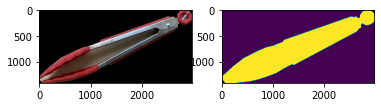

In [ ]:
## (1) Crop the bounding rect
file_path, bbox, poly, category = get_image_poly(old_annotations_train, 57)

print(file_path)

image, mask = img_preprocessing(file_path, bbox, poly)

f, axarr = plt.subplots(1,2)
axarr[0].imshow(image)
axarr[1].imshow(mask)

print(np.array(create_masks(image)).shape)

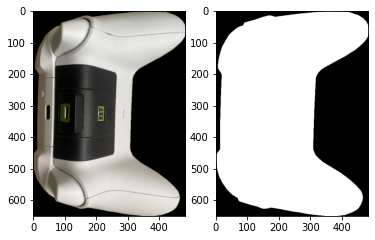

In [ ]:
re_image = resize(image, 20)
re_mask = resize(mask,  20)
mask_rbg = img_rgb = cv2.cvtColor(re_mask, cv2.COLOR_BGR2RGB)
f, axarr = plt.subplots(1,2)
axarr[0].imshow(re_image)
axarr[1].imshow(mask_rbg)

(1, 10117, 1, 2)


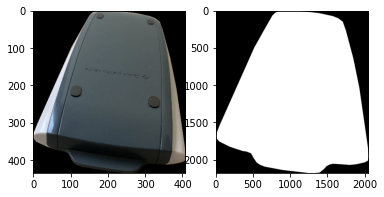

In [ ]:
## (1) Crop the bounding rect
file_path, bbox, poly, category = get_image_poly(old_annotations_train, 2)
image1, mask1 = img_preprocessing(file_path, bbox, poly)

mask1_rbg = cv2.cvtColor(mask1, cv2.COLOR_BGR2RGB)
re_image1 = resize(image1, 20)
re_mask1 = resize(mask1,  20)
f, axarr = plt.subplots(1,2)
axarr[0].imshow(re_image1)
axarr[1].imshow(mask1_rbg)



print(np.array(create_masks(image)).shape)

In [ ]:
#given the background image, we create mask the object inserted into the background image
def background_mask(background, obj_mask, distX, distY):
  bg = np.zeros((background.shape[0], background.shape[1]))
  bg = bg.astype(np.uint8)

  x, y = obj_mask.shape
  
  bg[distX:distX+x, distY:distY+y] = bg[distX:distX+x, distY:distY+y] + obj_mask

  return bg 

#given a background mask and a foreground mask, we crop out the background mask
def crop_mask(back_mask, front_mask):
  back_mask = back_mask - front_mask

  kernel = np.ones((3, 3), np.uint8)
  back_mask = cv2.erode(back_mask, kernel, iterations=1)
  
  _, mask = cv2.threshold(back_mask, 122, 255, cv2.THRESH_BINARY)

  return mask


def personalized_resized(image, mask, category):

    resized_image = resize(image, 18)
    resized_mask = resize(mask, 18)

    #if keyboard category
    if category == 8:
      resized_image = resize(image, 42)
      resized_mask = resize(mask, 42)
    # if hairbrush category
    elif category == 5:
      resized_image = resize(image, 23)
      resized_mask = resize(mask, 23)
    # if mouse category
    elif category == 9:
      resized_image = resize(image, 16)
      resized_mask = resize(mask, 16)



    return resized_image, resized_mask


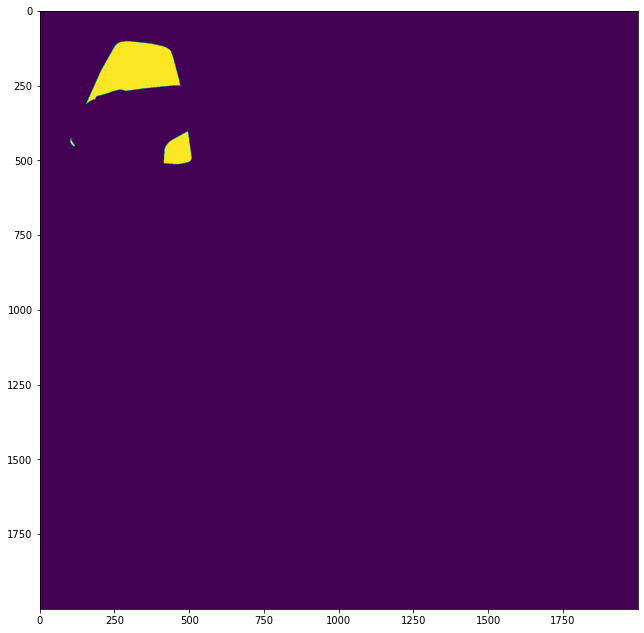

In [ ]:
b = np.zeros([2000,2000,3],dtype=np.uint8)
bg_1 = background_mask(b, re_mask1, 100, 100)
bg_2 = background_mask(b, re_mask, 250, 100)

res = crop_mask(bg_1, bg_2)
plt.figure(figsize=(11,11))
plt.imshow(res)

In [ ]:
def overlay(background, foreground, mask, destX = 500, destY = 250):

  results = background
  mask_boolean = np.stack([mask, mask, mask], axis=2)
  y1 = destY
  y2 = destY + foreground.shape[0]
  x1 = destX
  x2 = destX+foreground.shape[1]

  results[y1: y2, x1:x2, :] =  results[y1: y2, x1:x2, :] * ~mask_boolean[0:foreground.shape[0], 0:foreground.shape[1], :] + foreground
  results[y1: y2, x1:x2, :] =  results[y1: y2, x1:x2, :]  * ~mask_boolean[0:foreground.shape[0], 0:foreground.shape[1], :] + foreground

  bg_mask = background_mask(results, mask, destY, destX)


  return results, bg_mask

def choose_destination(background, obj):
    background_bbox = [700, 450, 2000, 1500] #[x, y, width, height]

    obj_length = obj.shape[1] #length in x_axis
    obj_height = obj.shape[0]  #length in y_axis

    x = int(background_bbox[2] - obj_length)
    y = int(background_bbox[3] - obj_height)
  
    destX =  random.choice(range(background_bbox[0], background_bbox[0] + x, 1)) 
    destY = random.choice(range(background_bbox[1],background_bbox[1] + y, 1))

    return destX, destY

def overlay_images(empty_tote, obj, obj_masks, obj_category):

  composite = empty_tote.copy()

  composite_masks = []
  composite_categories = []
  polygons = []
  bboxs = []
  categories = []
  areas = []

  for i in range(len(obj)):

    destX, destY = choose_destination(empty_tote, obj[i])
    composite, composite_mask = overlay(composite, obj[i], obj_masks[i], destX , destY)
    composite_masks.append(composite_mask)
  

  final_masks = composite_masks

  for i in reversed(range(len(composite_masks))):
    for j in range(i):
      final_masks[j] = crop_mask(back_mask= final_masks[j], front_mask=final_masks[i])


  for index, mask in enumerate(final_masks):

    contours, _ = cv2.findContours(image=mask, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_NONE)
    #iterate though every disjoint contour found in the image 
      #if the resulting area of an object is below a certain threshold, let remove it from consideration
    threshold = 1500
    for cont in contours:
      if len(cont) < 10:
        print(f"Skipping This Polygon.. Length of {len(cont)} too short")
        continue
      #get all details of a polygon, i.e. area, bounding box, category, segmentations
      cont = np.array(cont)
      area = cv2.contourArea(cont) #get the area of disjoint contour
      if area < threshold:
        print(f"Skipping This Polygon.. Area of {area} is too small")
        continue
      x, y, w, h = cv2.boundingRect(cont) #get the bounding box for each disjoint contour
      bbox = [x,y,w,h]
      category = obj_category[index]
      polygon = cont.reshape(cont.shape[0],2)

      #appending final items
      polygons.append(polygon)
      bboxs.append(bbox)
      categories.append(category)
      areas.append(area)






    

  return composite, polygons, bboxs, areas, categories


In [ ]:
def add_cluster_details(image, path, polygons, bbox, area, category, json_file):
    im = image.shape
    height, width = im[0], im[1]
    coco_file = None
    
    with open(json_file, "r") as file:
        coco_file = json.load(file)
    
    #cluster of objects in a single image will share the same "images" component
    image_id = len(coco_file["images"])
    
    image_details = {
        "id": image_id + 1,
        "height": height,
        "width": width,
        "file_name": "synthetic_im/"+str(os.path.basename(path)),
    }
    coco_file["images"].append(image_details)

    #each object will have unique annotations details 
    for i in range(len(polygons)):
      annotations_id = len(coco_file['annotations'])

      annotations_details = {
          "id": annotations_id + 1,
          "area": area[i],
          "iscrowd": 0,
          "image_id": image_id + 1,
          "bbox": bbox[i],
          "category_id": category[i],
          "segmentation": polygons[i]
      }
      
      
      coco_file["annotations"].append(annotations_details)
    
    with open(json_file, 'w') as file:
        json.dump(coco_file, file, indent = 4)





In [ ]:
def get_sample_array():

  image_index = list(range(89))
  random.shuffle(image_index)
  pieces = 11
  samples = np.array_split(image_index, pieces)

  return samples

In [ ]:
def pipeline(coco_file, rotate90 = False, rotate180 = False, rotate270 = False): 
  empty_tote = cv2.imread('/content/drive/MyDrive/Amazon Project/clutterizer_test/empty_tote.jpeg')
  empty_tote = cv2.cvtColor(empty_tote, cv2.COLOR_BGR2RGB) #cv2 reads images in BGR, this functions transforms to RGB

  all_samples = get_sample_array()
  for sample in all_samples:
    img = []
    masks = []
    categories = []
    for index in sample:
      file_path, bbox, poly, category = get_image_poly(old_annotations_train, index) #get orignal image
      image, mask = img_preprocessing(file_path, bbox, poly) #perform preprocessing 
      image, mask = personalized_resized(image, mask, category) #perform resizing
      if rotate90:
        image = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
        mask = cv2.rotate(mask, cv2.ROTATE_90_COUNTERCLOCKWISE)
      if rotate180:
        image = cv2.rotate(image, cv2.ROTATE_180)
        mask = cv2.rotate(mask, cv2.ROTATE_180)
      if rotate270:
        image = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
        mask = cv2.rotate(mask, cv2.ROTATE_90_COUNTERCLOCKWISE)




      img.append(image)
      masks.append(mask)
      categories.append(category)

    # detect the contours on the binary image using cv2.CHAIN_APPROX_NONE
    composition, contours, bbox_arr, areas, categor = overlay_images(empty_tote, img, masks, categories)

    composition = cv2.cvtColor(composition, cv2.COLOR_BGR2RGB)

    path = '/content/drive/MyDrive/Amazon Project/clutterized/synthetic_im/'
    image_name = str(uuid.uuid1()) + '.png'
    image_path = path + image_name
    cv2.imwrite(image_path, composition)

    print(f"generating image: {image_name}")
    

    polygons = []
    for i in range(len(contours)):
      polygon = contours[i]
      polygon = polygon.reshape(polygon.shape[0],2).tolist()
      polygons.append(polygon)
      
    add_cluster_details(composition, image_path, polygons, bbox_arr, areas, categor , coco_file)



In [ ]:
coco_file = '/content/drive/MyDrive/Amazon Project/clutterized/train.json'
pipeline(coco_file, rotate90= True)
pipeline(coco_file, rotate180= True)
pipeline(coco_file, rotate270= True)
pipeline(coco_file)



generating image: 7482dca8-c3e5-11ec-8162-0242ac1c0002.png
generating image: 788ce988-c3e5-11ec-8162-0242ac1c0002.png
Skipping This Polygon.. Area of 912.5 is too small
generating image: 7c63d170-c3e5-11ec-8162-0242ac1c0002.png
Skipping This Polygon.. Area of 1319.5 is too small
generating image: 8091dbc0-c3e5-11ec-8162-0242ac1c0002.png
Skipping This Polygon.. Length of 1 too short
Skipping This Polygon.. Area of 9.0 is too small
generating image: 845d2c28-c3e5-11ec-8162-0242ac1c0002.png
Skipping This Polygon.. Area of 260.0 is too small
generating image: 8802c57c-c3e5-11ec-8162-0242ac1c0002.png
Skipping This Polygon.. Area of 373.5 is too small
generating image: 8c237476-c3e5-11ec-8162-0242ac1c0002.png
generating image: 903dbcce-c3e5-11ec-8162-0242ac1c0002.png
Skipping This Polygon.. Area of 1219.0 is too small
generating image: 94adadd2-c3e5-11ec-8162-0242ac1c0002.png
Skipping This Polygon.. Area of 300.0 is too small
generating image: 98e8d9d0-c3e5-11ec-8162-0242ac1c0002.png
Skippin

In [ ]:
empty_tote = cv2.imread('/content/drive/MyDrive/Amazon Project/clutterizer_test/empty_tote.jpeg')
empty_tote = cv2.cvtColor(empty_tote, cv2.COLOR_BGR2RGB) #cv2 reads images in BGR, this functions transforms to RGB

#copy the image background
bg = empty_tote.copy()
height_bg, width_bg =  bg.shape[0], bg.shape[1]
print('Height of empty tote is: ' , height_bg, 'width is: ', width_bg)
print('This image is:', type(empty_tote), ' with dimensions:', empty_tote.shape)




Height of empty tote is:  2358 width is:  3545
This image is: <class 'numpy.ndarray'>  with dimensions: (2358, 3545, 3)
